ImprovedRegularizedSVD

In [6]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold

column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

class ImprovedRegularizedSVD:
    def __init__(self, num_users, num_items, num_factors=30, learning_rate=0.001, reg=0.02):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.learning_rate = learning_rate
        self.reg = reg

        self.P = np.random.normal(scale=1./self.num_factors, size=(self.num_users, self.num_factors))
        self.Q = np.random.normal(scale=1./self.num_factors, size=(self.num_items, self.num_factors))
        self.bias_user = np.zeros(self.num_users)
        self.bias_item = np.zeros(self.num_items)
        self.mu = np.mean(df['rating'])

    def predict(self, user, item):
        pred = (self.mu + self.bias_user[user] + self.bias_item[item] +
                np.dot(self.P[user, :], self.Q[item, :]))
        return pred

    def train(self, dataset, max_epochs=40, tolerance=0.01):
        for epoch in range(max_epochs):
            self.sgd(dataset)
            rmse = self.rmse(dataset)
            if rmse < tolerance:
                break

    def sgd(self, dataset):
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            err = rating - pred

            self.bias_user[user] += self.learning_rate * (err - self.reg * self.bias_user[user])
            self.bias_item[item] += self.learning_rate * (err - self.reg * self.bias_item[item])

            self.P[user, :] += self.learning_rate * (err * self.Q[item, :] - self.reg * self.P[user, :])
            self.Q[item, :] += self.learning_rate * (err * self.P[user, :] - self.reg * self.Q[item, :])

    def rmse(self, dataset):
        rmse = 0
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            rmse += (rating - pred) ** 2
        return math.sqrt(rmse / len(dataset))

    def mae(self, dataset):
        mae = 0
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            mae += abs(rating - pred)
        return mae / len(dataset)

    def precision(self, dataset, threshold = 3.6):
        y_true = []
        y_pred = []
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            y_true.append(1 if rating >= threshold else 0)
            y_pred.append(1 if pred >= threshold else 0)
        return precision_score(y_true, y_pred)

    def recall(self, dataset, threshold=3.6):
        y_true = []
        y_pred = []
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            y_true.append(1 if rating >= threshold else 0)
            y_pred.append(1 if pred >= threshold else 0)
        return recall_score(y_true, y_pred)

    def f1(self, dataset, threshold=3.6):
        y_true = []
        y_pred = []
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            y_true.append(1 if rating >= threshold else 0)
            y_pred.append(1 if pred >= threshold else 0)
        return f1_score(y_true, y_pred)

num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()

# Configuração da validação cruzada K-fold
kf = KFold(n_splits=6)

rmse_scores = []
mae_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
improved_y_true_all = []
improved_y_pred_all = []
threshold = 3.6
k= 0

for train_index, test_index in kf.split(df):
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]

    model = ImprovedRegularizedSVD(num_users, num_items)
    model.train(train_data)

    for _, row in test_data.iterrows():
        user = int(row['user_id']) - 1
        item = int(row['item_id']) - 1
        rating = row['rating']

        pred = model.predict(user, item)
        improved_y_true_all.append(1 if rating >= threshold else 0)
        improved_y_pred_all.append(1 if pred >= threshold else 0)

    print(k+1,"-fold")
    rmse_scores.append(model.rmse(test_data))
    print("RMSE:", rmse_scores[k])
    mae_scores.append(model.mae(test_data))
    print("MAE:", mae_scores[k])
    precision_scores.append(model.precision(test_data))
    print("Precision:", precision_scores[k])
    recall_scores.append(model.recall(test_data))
    print("Recall:", recall_scores[k])
    f1_scores.append(model.f1(test_data))
    print("f1:", f1_scores[k])
    k = k+1

print(f'RMSE Médio: {np.mean(rmse_scores)}')
print(f'MAE Médio: {np.mean(mae_scores)}')
print(f'Precision Médio: {np.mean(precision_scores)}')
print(f'Recall Médio: {np.mean(recall_scores)}')
print(f'F1-Score Médio: {np.mean(f1_scores)}')


1 -fold
RMSE: 0.9603424417559628
MAE: 0.7606307054400584
Precision: 0.7584710986047603
Recall: 0.6883379442434561
f1: 0.7217046912478384
2 -fold
RMSE: 0.9489471777349865
MAE: 0.7515682476547069
Precision: 0.7655642023346303
Recall: 0.6749571183533448
f1: 0.7174111212397447
3 -fold
RMSE: 0.9505274674980516
MAE: 0.7497916559779987
Precision: 0.7519689961245155
Recall: 0.6519618469542597
f1: 0.6984034833091437
4 -fold
RMSE: 0.9408698902039683
MAE: 0.744851044977853
Precision: 0.7484127972115026
Recall: 0.6566186107470511
f1: 0.6995171330502066
5 -fold
RMSE: 0.9376444137451065
MAE: 0.7442128325268277
Precision: 0.7548809673762439
Recall: 0.6569111038035734
f1: 0.7024967764623139
6 -fold
RMSE: 0.9461045052859393
MAE: 0.75062832665325
Precision: 0.7536516509144471
Recall: 0.6714785651793526
f1: 0.7101960557515471
RMSE Médio: 0.9474059827040024
MAE Médio: 0.7502804688717823
Precision Médio: 0.7554916187610167
Recall Médio: 0.666710864880173
F1-Score Médio: 0.7082882101767991


SVD com kfold 


In [7]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import math
import matplotlib.pyplot as plt

# Carregar dados
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('u.data', sep='\t', names=column_names)

class BasicSVD:
    def __init__(self, num_users, num_items, num_factors=30, learning_rate=0.001):
        self.num_users = num_users
        self.num_items = num_items
        self.num_factors = num_factors
        self.learning_rate = learning_rate

        self.P = np.random.normal(scale=1./self.num_factors, size=(self.num_users, self.num_factors))
        self.Q = np.random.normal(scale=1./self.num_factors, size=(self.num_items, self.num_factors))

    def predict(self, user, item):
        pred = np.dot(self.P[user, :], self.Q[item, :])
        return pred

    def train(self, dataset, max_epochs=40, tolerance=0.001):
        for epoch in range(max_epochs):
            self.sgd(dataset)
            rmse = self.rmse(dataset)
            if rmse < tolerance:
                break

    def sgd(self, dataset):
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            err = rating - pred

            self.P[user, :] += self.learning_rate * (err * self.Q[item, :])
            self.Q[item, :] += self.learning_rate * (err * self.P[user, :])

    def rmse(self, dataset):
        rmse = 0
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            rmse += (rating - pred) ** 2
        return math.sqrt(rmse / len(dataset))

    def mae(self, dataset):
        mae = 0
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            mae += abs(rating - pred)
        return mae / len(dataset)

    def precision(self, dataset, threshold=3.6):
        y_true = []
        y_pred = []
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            y_true.append(1 if rating >= threshold else 0)
            y_pred.append(1 if pred >= threshold else 0)
        return precision_score(y_true, y_pred)

    def recall(self, dataset, threshold=3.6):
        y_true = []
        y_pred = []
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            y_true.append(1 if rating >= threshold else 0)
            y_pred.append(1 if pred >= threshold else 0)
        return recall_score(y_true, y_pred)

    def f1(self, dataset, threshold=3.6):
        y_true = []
        y_pred = []
        for _, row in dataset.iterrows():
            user = int(row['user_id']) - 1
            item = int(row['item_id']) - 1
            rating = row['rating']

            pred = self.predict(user, item)
            y_true.append(1 if rating >= threshold else 0)
            y_pred.append(1 if pred >= threshold else 0)
        return f1_score(y_true, y_pred)
    

# Número de usuários e itens
num_users = df['user_id'].nunique()
num_items = df['item_id'].nunique()

# Inicializar k-fold
kf = KFold(n_splits=6, shuffle=True, random_state=42)

rmse_list = []
mae_list = []
precision_list = []
recall_list = []
f1_list = []
y_true_all = []
y_pred_all = []
threshold = 3.6

k = 0
for train_index, test_index in kf.split(df):
    train_data = df.iloc[train_index]
    test_data = df.iloc[test_index]

    model = BasicSVD(num_users, num_items)
    model.train(train_data)

    for _, row in test_data.iterrows():
        user = int(row['user_id']) - 1
        item = int(row['item_id']) - 1
        rating = row['rating']

        pred = model.predict(user, item)
        y_true_all.append(1 if rating >= threshold else 0)
        y_pred_all.append(1 if pred >= threshold else 0)

    rmse = model.rmse(test_data)
    mae = model.mae(test_data)
    precision = model.precision(test_data)
    recall = model.recall(test_data)
    f1 = model.f1(test_data)

    print(k+1, "-fold")
    print("RMSE:", rmse)
    print("MAE:", mae)
    print("Precision:", precision)
    print("Recall:", recall)
    print("f1:", f1)
    k = k + 1

    rmse_list.append(rmse)
    mae_list.append(mae)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

print(f'RMSE médio: {np.mean(rmse_list)}')
print(f'MAE médio: {np.mean(mae_list)}')
print(f'Precisão médio: {np.mean(precision_list)}')
print(f'Recall médio: {np.mean(recall_list)}')
print(f'F1-Score: {np.mean(f1_list)}')


1 -fold
RMSE: 1.003631017829949
MAE: 0.7784658491131973
Precision: 0.7605085625324338
Recall: 0.6400262037340321
f1: 0.6950850773700125
2 -fold
RMSE: 1.0148971219204221
MAE: 0.7901274710152116
Precision: 0.7561791967044285
Recall: 0.6370241839279904
f1: 0.6915062687621402
3 -fold
RMSE: 1.012088066836523
MAE: 0.7814728704899401
Precision: 0.764788552446659
Recall: 0.652353966870096
f1: 0.7041110392283715
4 -fold
RMSE: 1.0200892462806224
MAE: 0.7930171519859768
Precision: 0.7625588697017268
Recall: 0.627719147103166
f1: 0.6886001181334909
5 -fold
RMSE: 1.0118496871298956
MAE: 0.784542645911696
Precision: 0.7593436645396536
Recall: 0.6286792452830189
f1: 0.6878612716763006
6 -fold
RMSE: 1.012292754445759
MAE: 0.7883886615596528
Precision: 0.7702278083267872
Recall: 0.635450421257291
f1: 0.6963778409090909
RMSE médio: 1.0124746490738619
MAE médio: 0.7860024416792791
Precisão médio: 0.7622677757086148
Recall médio: 0.6368755280292656
F1-Score: 0.693923602679901


Comparação de resultados : 

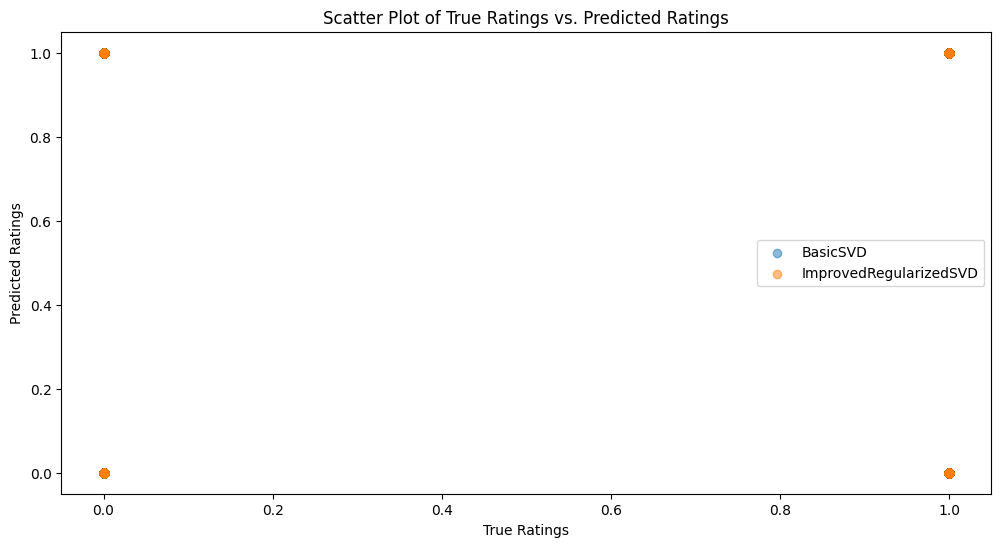

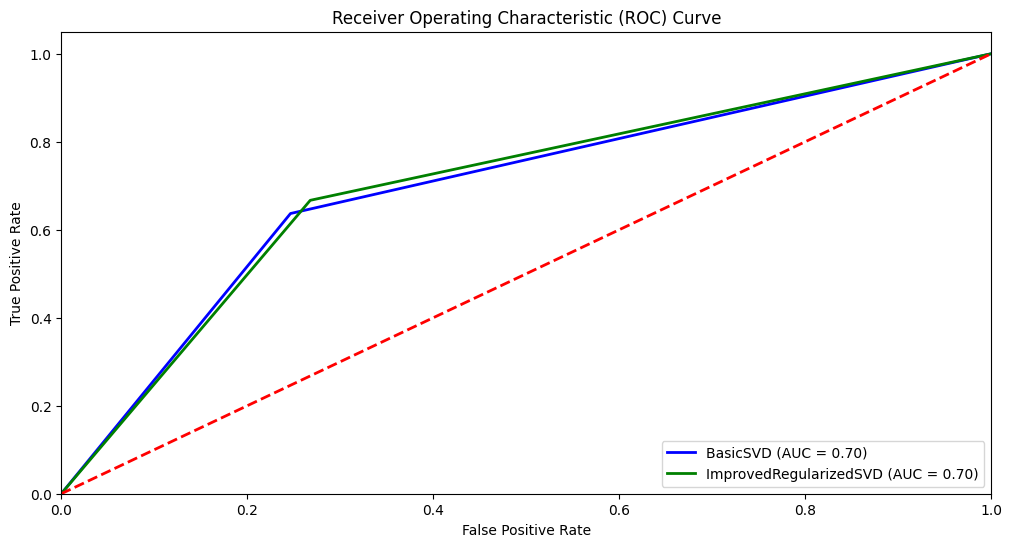

In [9]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Visualizações
# Gráfico de dispersão das previsões vs. valores reais
plt.figure(figsize=(12, 6))
plt.scatter(y_true_all, y_pred_all, alpha=0.5, label='BasicSVD')
plt.scatter(improved_y_true_all, improved_y_pred_all, alpha=0.5, label='ImprovedRegularizedSVD')
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.legend()
plt.title('Scatter Plot of True Ratings vs. Predicted Ratings')
plt.show()

# Curvas ROC
fpr, tpr, _ = roc_curve(y_true_all, y_pred_all)
roc_auc = auc(fpr, tpr)
improved_fpr, improved_tpr, _ = roc_curve(improved_y_true_all, improved_y_pred_all)
improved_roc_auc = auc(improved_fpr, improved_tpr)

plt.figure(figsize=(12, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='BasicSVD (AUC = %0.2f)' % roc_auc)
plt.plot(improved_fpr, improved_tpr, color='green', lw=2, label='ImprovedRegularizedSVD (AUC = %0.2f)' % improved_roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()